In [1]:
from transformers import RobertaTokenizer
from transformers import RobertaForSequenceClassification
from transformers import Trainer
from transformers import TrainingArguments


C:\Users\uma_s\anaconda3\envs\reinforcement-learning\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [47]:
from pprint import pprint
import re
import pandas as pd 
import numpy as np
import seaborn as sns 
import torch
import matplotlib.pyplot as plt
import nltk 
from nltk.sentiment import SentimentIntensityAnalyzer as SIA
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report, roc_auc_score

In [3]:
print("PyTorch version:", torch.__version__)
print("GPU Available:", torch.cuda.is_available())
print("Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")

PyTorch version: 2.5.1+cu124
GPU Available: True
Device Name: NVIDIA GeForce RTX 4050 Laptop GPU


In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\uma_s\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\uma_s\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [6]:
df = pd.read_csv('reddit_nba_master_data.csv')

In [7]:
df.head()

,Title,ID,Author,Name,Author Flair Text,# Comments,Time,# Upvotes,Link,Upvote Ratio
0,Daily Discussion Thread + Game Thread Index,1hybybh,NBA_MOD,t3_1hybybh,r/NBA,5,1.736536e+09,9,https://www.reddit.com/r/nba/comments/1hybybh/...,0.92
1,Weekly Friday Self-Promotion and Fan Art Thread,1hy3vjo,NBA_MOD,t3_1hy3vjo,r/NBA,0,1.736514e+09,6,https://www.reddit.com/r/nba/comments/1hy3vjo/...,0.88
2,Jimmy Butler on his Instagram story to his Big...,1hy64xk,YujiDomainExpansion,t3_1hy64xk,NaN,1476,1.736521e+09,11827,https://streamable.com/9zqmf3,0.93
3,"Jarrett Allen explains Ethical Basketball: ""Fa...",1hxwrre,2131andBeyond,t3_1hxwrre,:cle-5: Cavaliers,409,1.736485e+09,9988,https://streamable.com/uo94x4,0.97
4,Joe Mazzulla goes in depth on what his typical...,1hxy23z,SliMShady55222,t3_1hxy23z,:sea-1: Supersonics,252,1.736490e+09,6170,https://streamable.com/u9yy46,0.98


In [8]:
df.shape

(121766, 10)

In [9]:
#dropping duplicate rows
df = df.drop_duplicates()

In [10]:
df.shape

(111646, 10)

In [11]:
#making the title column a list to then assign sentiment labels
title_list = df['Title'].tolist()
type(title_list[0])

str

In [12]:
sia = SIA()
results = []

for title in title_list: 
    pol_score = sia.polarity_scores(title)
    pol_score['Title'] = title
    results.append(pol_score)

In [13]:
pprint(results[:3], width=100)

[{'Title': 'Daily Discussion Thread + Game Thread Index',
  'compound': 0.0,
  'neg': 0.0,
  'neu': 1.0,
  'pos': 0.0},
 {'Title': 'Weekly Friday Self-Promotion and Fan Art Thread',
  'compound': 0.3182,
  'neg': 0.0,
  'neu': 0.723,
  'pos': 0.277},
 {'Title': 'Jimmy Butler on his Instagram story to his Big Face Coffee employee: “Our best guy '
           'right here. You see that? See that? I gave you a compliment. That’s what bosses do. '
           'They build you up they don’t break you down.”',
  'compound': 0.8253,
  'neg': 0.0,
  'neu': 0.825,
  'pos': 0.175}]


In [14]:
titles_and_labels = pd.DataFrame.from_records(results)
titles_and_labels.head()

,neg,neu,pos,compound,Title
0,0.0,1.000,0.000,0.0000,Daily Discussion Thread + Game Thread Index
1,0.0,0.723,0.277,0.3182,Weekly Friday Self-Promotion and Fan Art Thread
2,0.0,0.825,0.175,0.8253,Jimmy Butler on his Instagram story to his Big...
3,0.0,0.577,0.423,0.7650,"Jarrett Allen explains Ethical Basketball: ""Fa..."
4,0.0,0.848,0.152,0.3612,Joe Mazzulla goes in depth on what his typical...


In [15]:
titles_and_labels.shape

(111646, 5)

In [16]:
titles_and_labels['label'] = 1 #neutral
titles_and_labels.loc[titles_and_labels['compound'] > 0.1, 'label'] = 2 #positive
titles_and_labels.loc[titles_and_labels['compound'] < -0.1, 'label'] = 0 #negative
titles_and_labels.head()

,neg,neu,pos,compound,Title,label
0,0.0,1.000,0.000,0.0000,Daily Discussion Thread + Game Thread Index,1
1,0.0,0.723,0.277,0.3182,Weekly Friday Self-Promotion and Fan Art Thread,2
2,0.0,0.825,0.175,0.8253,Jimmy Butler on his Instagram story to his Big...,2
3,0.0,0.577,0.423,0.7650,"Jarrett Allen explains Ethical Basketball: ""Fa...",2
4,0.0,0.848,0.152,0.3612,Joe Mazzulla goes in depth on what his typical...,2


In [17]:
neg = titles_and_labels['neg'].tolist()
compound = titles_and_labels['compound'].tolist()
neu = titles_and_labels['neu'].tolist()
pos = titles_and_labels['pos'].tolist()
label = titles_and_labels['label'].tolist()

In [18]:
df['neg'] = neg
df['neu'] = neu
df['pos'] = pos
df['compound'] = compound
df['label'] = label

In [19]:
df.head()

,Title,ID,Author,Name,Author Flair Text,# Comments,Time,# Upvotes,Link,Upvote Ratio,neg,neu,pos,compound,label
0,Daily Discussion Thread + Game Thread Index,1hybybh,NBA_MOD,t3_1hybybh,r/NBA,5,1.736536e+09,9,https://www.reddit.com/r/nba/comments/1hybybh/...,0.92,0.0,1.000,0.000,0.0000,1
1,Weekly Friday Self-Promotion and Fan Art Thread,1hy3vjo,NBA_MOD,t3_1hy3vjo,r/NBA,0,1.736514e+09,6,https://www.reddit.com/r/nba/comments/1hy3vjo/...,0.88,0.0,0.723,0.277,0.3182,2
2,Jimmy Butler on his Instagram story to his Big...,1hy64xk,YujiDomainExpansion,t3_1hy64xk,NaN,1476,1.736521e+09,11827,https://streamable.com/9zqmf3,0.93,0.0,0.825,0.175,0.8253,2
3,"Jarrett Allen explains Ethical Basketball: ""Fa...",1hxwrre,2131andBeyond,t3_1hxwrre,:cle-5: Cavaliers,409,1.736485e+09,9988,https://streamable.com/uo94x4,0.97,0.0,0.577,0.423,0.7650,2
4,Joe Mazzulla goes in depth on what his typical...,1hxy23z,SliMShady55222,t3_1hxy23z,:sea-1: Supersonics,252,1.736490e+09,6170,https://streamable.com/u9yy46,0.98,0.0,0.848,0.152,0.3612,2


In [20]:
pd.crosstab(index=df["label"], columns="count")

col_0,count
label,
0,19947
1,57063
2,34636


In [21]:
#Remove Irrelevant Characters
def remove_irrelevant_characters(text):
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # Remove URLs
    text = re.sub(r"<.*?>", "", text)  # Remove HTML tags
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters
    return text

In [22]:
#Convert Text to Lowercase
def to_lowercase(text):
    return text.lower()

In [23]:
#Remove Stop Words
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return " ".join(filtered_words)

In [24]:
#Stemming 
stemmer = PorterStemmer()

def stem_words(text):
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    return " ".join(stemmed_words)

In [25]:
#Whitespace Normalization
def normalize_whitespace(text):
    return " ".join(text.split())

In [26]:
#all functions in a pipelineabs
def clean_text_pipeline(text):
    text = remove_irrelevant_characters(text)
    text = to_lowercase(text)
    text = remove_stopwords(text)
    text = normalize_whitespace(text)
    return text

In [27]:
df["Cleaned Titles"] = df["Title"].apply(clean_text_pipeline)

In [28]:
df

,Title,ID,Author,Name,Author Flair Text,# Comments,Time,# Upvotes,Link,Upvote Ratio,neg,neu,pos,compound,label,Cleaned Titles
0,Daily Discussion Thread + Game Thread Index,1hybybh,NBA_MOD,t3_1hybybh,r/NBA,5,1.736536e+09,9,https://www.reddit.com/r/nba/comments/1hybybh/...,0.92,0.000,1.000,0.000,0.0000,1,daily discussion thread game thread index
1,Weekly Friday Self-Promotion and Fan Art Thread,1hy3vjo,NBA_MOD,t3_1hy3vjo,r/NBA,0,1.736514e+09,6,https://www.reddit.com/r/nba/comments/1hy3vjo/...,0.88,0.000,0.723,0.277,0.3182,2,weekly friday selfpromotion fan art thread
2,Jimmy Butler on his Instagram story to his Big...,1hy64xk,YujiDomainExpansion,t3_1hy64xk,NaN,1476,1.736521e+09,11827,https://streamable.com/9zqmf3,0.93,0.000,0.825,0.175,0.8253,2,jimmy butler instagram story big face coffee e...
3,"Jarrett Allen explains Ethical Basketball: ""Fa...",1hxwrre,2131andBeyond,t3_1hxwrre,:cle-5: Cavaliers,409,1.736485e+09,9988,https://streamable.com/uo94x4,0.97,0.000,0.577,0.423,0.7650,2,jarrett allen explains ethical basketball farm...
4,Joe Mazzulla goes in depth on what his typical...,1hxy23z,SliMShady55222,t3_1hxy23z,:sea-1: Supersonics,252,1.736490e+09,6170,https://streamable.com/u9yy46,0.98,0.000,0.848,0.152,0.3612,2,joe mazzulla goes depth typical conversations ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121757,Oblique strains are far less common in the NBA...,1ggogh5,ILikeDillonBrooks,t3_1ggogh5,DPSF,5,1.730407e+09,23,https://x.com/instreetclothes/status/185205816...,0.96,0.199,0.801,0.000,-0.6908,0,oblique strains far less common nba sports par...
121758,Bane and Smart out,1ggkx6z,Altruistic_Brief4444,t3_1ggkx6z,DB,46,1.730398e+09,36,https://i.redd.it/89eprmzlt4yd1.jpeg,0.97,0.000,0.526,0.474,0.4019,2,bane smart
121761,HAPPY JALLOWEEN!! Will it be Trick or Treat fo...,1ggeap3,nam67,t3_1ggeap3,HUFF DADDY,90,1.730381e+09,37,https://www.reddit.com/r/memphisgrizzlies/comm...,0.98,0.045,0.669,0.287,0.8185,2,happy jalloween trick treat memphis tonight gr...
121762,Dicks Sporting Goods has some 23/24 city editi...,1gghtyv,liltrikz,t3_1gghtyv,NaN,7,1.730390e+09,18,https://i.redd.it/s50g97tv54yd1.jpeg,0.96,0.000,0.893,0.107,0.3400,2,dicks sporting goods city edition gear sale ha...


In [29]:
#Splitting dataset

train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df["Cleaned Titles"], df["label"], test_size=0.3, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42)

In [30]:
#tokenization

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
def tokenize_data(texts, labels):
    tokenized_inputs = tokenizer(
        texts.tolist(),
        truncation=True,
        padding=True,
        max_length=512,
        return_tensors="pt"
    )
    tokenized_inputs["labels"] = torch.tensor(labels.tolist())
    return tokenized_inputs

train_data = tokenize_data(train_texts, train_labels)
val_data = tokenize_data(val_texts, val_labels)
test_data = tokenize_data(test_texts, test_labels)

In [31]:
#Preparing the dataset class 
class RedditDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return len(self.encodings["input_ids"])

    def __getitem__(self, idx):
        return {key: tensor[idx] for key, tensor in self.encodings.items()}

train_dataset = RedditDataset(train_data)
val_dataset = RedditDataset(val_data)
test_dataset = RedditDataset(test_data)


In [33]:
# Define and Fine-Tune the Model 

model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=3) 

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="steps",
    save_strategy="steps",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    logging_dir="./logs",
    logging_steps=1000,
    eval_steps = 1000, 
    save_steps = 1000, 
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
trainer.train()

Step,Training Loss,Validation Loss
1000,0.482900,0.358557
2000,0.331100,0.293025
3000,0.278900,0.286928
4000,0.252300,0.259402
5000,0.231800,0.253292
6000,0.204600,0.249507
7000,0.194800,0.242352


TrainOutput(global_step=7329, training_loss=0.27887309643431435, metrics={'train_runtime': 26785.9167, 'train_samples_per_second': 8.753, 'train_steps_per_second': 0.274, 'total_flos': 1.2289509737533728e+16, 'train_loss': 0.27887309643431435, 'epoch': 3.0})

In [50]:
#predicting on test data
predictions = trainer.predict(test_dataset)
y_pred = predictions.predictions.argmax(axis=1)
y_true = test_labels

In [55]:
type(y_pred)

numpy.ndarray

In [56]:
print(y_true)

55632     1
10373     0
118580    1
89366     1
88725     2
         ..
119854    0
13695     2
73940     2
105386    1
17446     2
Name: label, Length: 16747, dtype: int64


Accuracy: 0.9303158774705917
Precision: 0.9311372772513802
Recall: 0.9303158774705917
F1-Score: 0.930507577004535


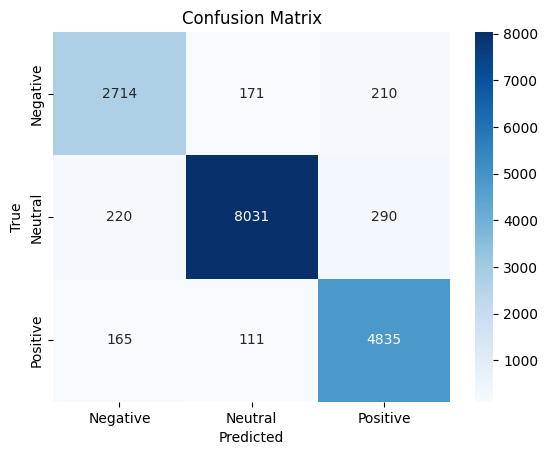

In [57]:
#evaluation

accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])  # Adjust labels for your classes
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [58]:
print(classification_report(y_true, y_pred, target_names=["Negative", "Neutral", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.88      0.88      0.88      3095
     Neutral       0.97      0.94      0.95      8541
    Positive       0.91      0.95      0.93      5111

    accuracy                           0.93     16747
   macro avg       0.92      0.92      0.92     16747
weighted avg       0.93      0.93      0.93     16747



In [60]:
#next steps to make the model better
#1. try using the other features in addition to just the cleaned titles 
#2. try out different model parameters that focuses on better accuracy and performance
#3. check if the imbalance between neutral, negative, and positive texts is throwing it off and look to counteract this